# Deep Learning Homework 2
**Pfeifer Dániel<br>
N65V6V**

The Original Notebook belongs to the authors, Gyires-Tóth Bálint & Császár Márk at the Budapest University of Technology and Economics for the "Deep Learning a gyakorlatban Python és LUA alapon" lecture: http://smartlab.tmit.bme.hu/oktatas-deep-learning.


Our homework was to modify the code to include:
- Momentum
- L1 & L2 regularization


The injected code can be found at
- `# HF2 start momentum (Part 1)`,
- `# HF2 start momentum (Part 2)`
- and `# HF2 start l1reg, l2reg`.

### Neural Network code with modifications and additions

In [1]:
import numpy as np
from sklearn import preprocessing
import copy
import matplotlib.pyplot as plt

In [2]:
def activation(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

I've modified both the `MLP` class and the `learn` function:

In [4]:
class MLP:
    
    def __init__(self, *args):
        np.random.seed(123)
        self.shape = args
        n = len(args)
        self.layers = []
        self.layers.append(np.ones(self.shape[0]+1))
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        self.dw = [0,]*len(self.weights)
        self.reset()
    
    def reset(self):
        for i in range(len(self.weights)):
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            self.weights[i][...] = (2*Z-1)*1

    def propagate_forward(self, data):
        self.layers[0][0:-1] = data
        for i in range(1,len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],self.weights[i-1]))
        return self.layers[-1]

    def propagate_backward(self, return_deltas, target, lrate=0.1, L1_regularization_coeff=0, L2_regularization_coeff=0):
        deltas = []
        error = -(target-self.layers[-1]) # y-y_kalap
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2],self.weights[-1])))
        deltas.append(delta)
        for i in range(len(self.shape)-2,0,-1):
            delta=np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)            
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            dw = -lrate*np.dot(layer.T,delta)
            self.weights[i] += dw 

            self.dw[i] = dw
        
        # HF2 start momentum (Part 1)
        # Using the Momentum Method, the delta parameter now includes all previous deltas
        # (exponentially weighted, if we've measured a delta n steps ago, its weight is
        # momentum_coeff ^ n, where momentum_coeff is in (0,1)).
        # We need to add up multiple deltas, however, the first delta will be the one calculated here:
        if(len(return_deltas) != 0):
            for d in range(len(deltas)):
                return_deltas[d] += deltas[d]
        # Otherwise, if its not the first delta, we just add it to the previous ones
        # (as seen in the 'learn' function)
        else:
            return_deltas = deltas
        # HF2 end momentum (Part 1)
        
        # HF2 start l1reg, l2reg
        # The L1 regularization error term is the sum of the absolute value of all weights:
        L1_reg_error = L1_regularization_coeff * sum([np.absolute(w).sum() for w in self.weights])
        # The L2 regularization error term is the sum of the square of all wrights:
        L2_reg_error = L2_regularization_coeff * sum([(w ** 2).sum() for w in self.weights])
        
        # The returned error now contains the weighted L1 & L2 error terms.
        # The final function can be called with e.g. L1_regularization_coeff=0.03,
        # and then the L1 regularization will be used.
        # Similarly for L2: e.g. L2_regularization_coeff=0.01 will apply a small weighted
        # L2 regularization error term.
        return return_deltas, (error**2).sum() + L1_reg_error + L2_reg_error
        # HF2 end l1reg, l2reg

In [5]:
def learn(network, X, Y, valid_split, test_split, epochs=20, lrate=0.1, L1_regularization_coeff=0, L2_regularization_coeff=0, momentum_coeff=0):

        # train-validation-test minták különválasztása
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test  = X[int(nb_samples*(1-test_split)):]
        Y_test  = Y[int(nb_samples*(1-test_split)):]
    
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)
    
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]
        
        for i in range(epochs):
            train_err = 0
            # HF2 momentum start (Part 2) (and additions for L1, L2 regularization)
            # The deltas parameter is now called outside the 'propagate_backward' method.
            # This will contain the current gradiant, plus all the previous deltas,
            # exponentially weighted. (See the 'propagate_backward' method.)
            deltas = []
            for k in range(X_train.shape[0]):
                network.propagate_forward( X_train[k] )
                # The 'propagate_backward' method gives has 2 outputs: The 'cur_err' parameter, containing
                # the current error calculated after the gradiant descent; and the new 'new_deltas'
                # parameter, containing the previous weighted deltas and the new one that was added to them.
                new_deltas, cur_err = network.propagate_backward( deltas, Y_train[k], lrate, L1_regularization_coeff, L2_regularization_coeff )
                train_err += cur_err
                deltas = new_deltas
                # Giving expnential weights is actually very simple, turns out if we simply multiply the previous
                # output by 'momentum_coeff' in every step, then each previously calculated delta will get +1 in its
                # 'momentum_coeff' exponent:
                # For example if 'momentum_coeff' = 0.9, and d(i) = delta calculated in the i'th step, then:
                # d(n) = 0.9^n * d(0) + 0.9^(n-1) * d(1) + 0.9^(n-2) * d(2) + ... + 0.9^2 * d(n-2) + 0.9 * d(n-1).
                # Meaning we take each delta less into consideration if it appeared a while ago, and
                # more into consideration if it appeared not too long ago.
                for d in range(len(deltas)):
                    deltas[d] = deltas[d] * momentum_coeff
            # HF2 momentum end (Part 2)
            train_err /= X_train.shape[0]

            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = network.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]

            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

        print("\n--- TESTING ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = network.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (expected result: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]

        fig1=plt.figure()
        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)

### Input data: Classify noisy XOR

In [6]:
network = MLP(2,10,1)

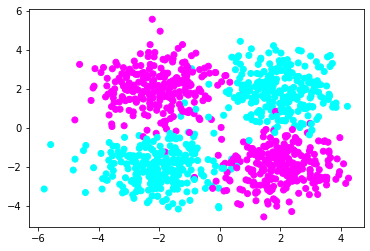

In [7]:
nb_samples=1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

fig1=plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.cool)

### Classification with examples for Momentum, L1 & L2 Regularization

**Classification using the Neural Network without any modifications:**

0 epoch, train_err: 0.2461, valid_err: 0.2378
1 epoch, train_err: 0.2297, valid_err: 0.2212
2 epoch, train_err: 0.2070, valid_err: 0.1934
3 epoch, train_err: 0.1742, valid_err: 0.1585
4 epoch, train_err: 0.1387, valid_err: 0.1267
5 epoch, train_err: 0.1098, valid_err: 0.1035
6 epoch, train_err: 0.0897, valid_err: 0.0879
7 epoch, train_err: 0.0764, valid_err: 0.0773
8 epoch, train_err: 0.0673, valid_err: 0.0700
9 epoch, train_err: 0.0610, valid_err: 0.0647
10 epoch, train_err: 0.0564, valid_err: 0.0606
11 epoch, train_err: 0.0529, valid_err: 0.0575
12 epoch, train_err: 0.0502, valid_err: 0.0551
13 epoch, train_err: 0.0480, valid_err: 0.0531
14 epoch, train_err: 0.0462, valid_err: 0.0514
15 epoch, train_err: 0.0447, valid_err: 0.0500
16 epoch, train_err: 0.0434, valid_err: 0.0488
17 epoch, train_err: 0.0422, valid_err: 0.0477
18 epoch, train_err: 0.0413, valid_err: 0.0468
19 epoch, train_err: 0.0404, valid_err: 0.0460

--- TESTING ---

0 [-0.49551261 -0.7444607 ] 0.18  (expected result: 

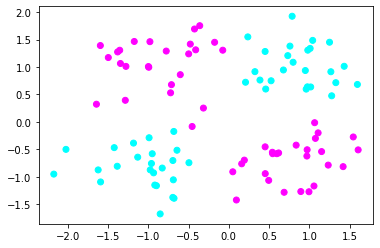

In [8]:
network.reset()
learn(network, X, Y, 0.2, 0.1)

**With Momentum:**

0 epoch, train_err: 0.2575, valid_err: 0.2487
1 epoch, train_err: 0.2515, valid_err: 0.2455
2 epoch, train_err: 0.2472, valid_err: 0.2403
3 epoch, train_err: 0.2395, valid_err: 0.2306
4 epoch, train_err: 0.2253, valid_err: 0.2131
5 epoch, train_err: 0.2017, valid_err: 0.1865
6 epoch, train_err: 0.1699, valid_err: 0.1549
7 epoch, train_err: 0.1366, valid_err: 0.1260
8 epoch, train_err: 0.1091, valid_err: 0.1041
9 epoch, train_err: 0.0894, valid_err: 0.0890
10 epoch, train_err: 0.0760, valid_err: 0.0787
11 epoch, train_err: 0.0667, valid_err: 0.0715
12 epoch, train_err: 0.0601, valid_err: 0.0662
13 epoch, train_err: 0.0553, valid_err: 0.0623
14 epoch, train_err: 0.0516, valid_err: 0.0592
15 epoch, train_err: 0.0488, valid_err: 0.0568
16 epoch, train_err: 0.0465, valid_err: 0.0548
17 epoch, train_err: 0.0446, valid_err: 0.0531
18 epoch, train_err: 0.0430, valid_err: 0.0517
19 epoch, train_err: 0.0417, valid_err: 0.0505

--- TESTING ---

0 [-0.49551261 -0.7444607 ] 0.11  (expected result: 

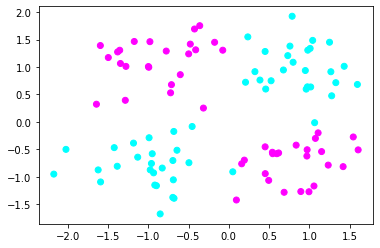

In [9]:
network.reset()
learn(network, X, Y, 0.2, 0.1, momentum_coeff=0.9)

**With L1 regularization:**

0 epoch, train_err: 0.8524, valid_err: 0.2498
1 epoch, train_err: 0.8749, valid_err: 0.2411
2 epoch, train_err: 0.9293, valid_err: 0.2259
3 epoch, train_err: 1.0118, valid_err: 0.2014
4 epoch, train_err: 1.1134, valid_err: 0.1705
5 epoch, train_err: 1.2208, valid_err: 0.1408
6 epoch, train_err: 1.3226, valid_err: 0.1179
7 epoch, train_err: 1.4126, valid_err: 0.1018
8 epoch, train_err: 1.4945, valid_err: 0.0905
9 epoch, train_err: 1.5681, valid_err: 0.0824
10 epoch, train_err: 1.6334, valid_err: 0.0763
11 epoch, train_err: 1.6918, valid_err: 0.0714
12 epoch, train_err: 1.7443, valid_err: 0.0674
13 epoch, train_err: 1.7919, valid_err: 0.0640
14 epoch, train_err: 1.8351, valid_err: 0.0611
15 epoch, train_err: 1.8744, valid_err: 0.0586
16 epoch, train_err: 1.9102, valid_err: 0.0565
17 epoch, train_err: 1.9430, valid_err: 0.0547
18 epoch, train_err: 1.9731, valid_err: 0.0532
19 epoch, train_err: 2.0009, valid_err: 0.0518

--- TESTING ---

0 [-0.49551261 -0.7444607 ] 0.15  (expected result: 

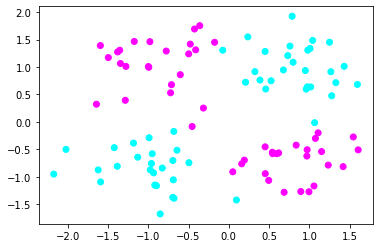

In [10]:
network.reset()
learn(network, X, Y, 0.2, 0.1, L1_regularization_coeff=0.03)

**With L2 regularization:**

0 epoch, train_err: 0.3614, valid_err: 0.2504
1 epoch, train_err: 0.3519, valid_err: 0.2467
2 epoch, train_err: 0.3545, valid_err: 0.2419
3 epoch, train_err: 0.3642, valid_err: 0.2334
4 epoch, train_err: 0.3841, valid_err: 0.2178
5 epoch, train_err: 0.4196, valid_err: 0.1942
6 epoch, train_err: 0.4755, valid_err: 0.1670
7 epoch, train_err: 0.5507, valid_err: 0.1429
8 epoch, train_err: 0.6370, valid_err: 0.1250
9 epoch, train_err: 0.7246, valid_err: 0.1127
10 epoch, train_err: 0.8069, valid_err: 0.1044
11 epoch, train_err: 0.8814, valid_err: 0.0987
12 epoch, train_err: 0.9478, valid_err: 0.0948
13 epoch, train_err: 1.0066, valid_err: 0.0919
14 epoch, train_err: 1.0588, valid_err: 0.0898
15 epoch, train_err: 1.1052, valid_err: 0.0882
16 epoch, train_err: 1.1467, valid_err: 0.0870
17 epoch, train_err: 1.1839, valid_err: 0.0860
18 epoch, train_err: 1.2175, valid_err: 0.0853
19 epoch, train_err: 1.2479, valid_err: 0.0846

--- TESTING ---

0 [-0.49551261 -0.7444607 ] 0.34  (expected result: 

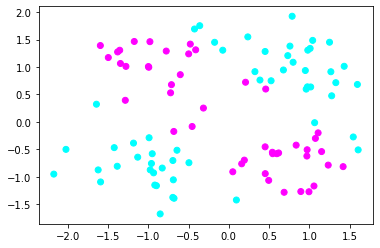

In [11]:
network.reset()
learn(network, X, Y, 0.2, 0.1, L2_regularization_coeff=0.01)

**Note:** All the above methods can be used at once. Though this wouldn't make sense for both L1 & L2 regularization, however for example Momentum & L2 regularization can be used together:

**Example: With Momentum & L2 regularization:**

0 epoch, train_err: 0.4922, valid_err: 0.2413
1 epoch, train_err: 0.5265, valid_err: 0.2295
2 epoch, train_err: 0.6002, valid_err: 0.2087
3 epoch, train_err: 0.7285, valid_err: 0.1783
4 epoch, train_err: 0.9166, valid_err: 0.1449
5 epoch, train_err: 1.1467, valid_err: 0.1170
6 epoch, train_err: 1.3881, valid_err: 0.0970
7 epoch, train_err: 1.6179, valid_err: 0.0834
8 epoch, train_err: 1.8271, valid_err: 0.0742
9 epoch, train_err: 2.0147, valid_err: 0.0677
10 epoch, train_err: 2.1828, valid_err: 0.0630
11 epoch, train_err: 2.3341, valid_err: 0.0595
12 epoch, train_err: 2.4713, valid_err: 0.0568
13 epoch, train_err: 2.5966, valid_err: 0.0547
14 epoch, train_err: 2.7119, valid_err: 0.0530
15 epoch, train_err: 2.8186, valid_err: 0.0516
16 epoch, train_err: 2.9180, valid_err: 0.0504
17 epoch, train_err: 3.0110, valid_err: 0.0495
18 epoch, train_err: 3.0984, valid_err: 0.0486
19 epoch, train_err: 3.1809, valid_err: 0.0479

--- TESTING ---

0 [-0.49551261 -0.7444607 ] 0.11  (expected result: 

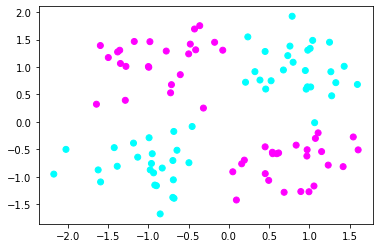

In [12]:
network.reset()
learn(network, X, Y, 0.2, 0.1, momentum_coeff=0.9, L2_regularization_coeff=0.02)

**Note 2:** Though the random state does get set in the definition of the network, something else also sets a different random state, and the results will turn out to be different after every run. Nonetheless, the Momentum, L1 & L2 Regularization methods do take effect.